In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import glob
import utils

In [4]:
min_lat=50;max_lat=24;
min_lon=235;max_lon=294;

In [86]:
def plot_cumulative_fdd(ds, ilon,ilat,temp_var='temperature', units='F',year=None,
                              start_month=8, end_month=7):
    """
    Plot cumulative FDD curve for a specific cold season to visualize the Bilotta AFI calculation.

    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        The dataset containing temperature data coordinates name
        should be "time","lat","lon"
    temp_var : str, optional
        Name of temperature variable if ds is a Dataset (default: 'temperature')
    threshold : float, optional
        Freezing threshold temperature (default: 0°C)
    year : int, optional
        The year representing the end of the cold season to plot (default: None, uses the first full season)
    start_month : int, optional
        Start month of the cold season (default: 8 for August)
    end_month : int, optional
        End month of the cold season (default: 7 for July)
    """
    if units=='F':
      threshold=32
    else:      print('error units /n convert to F')

    # Select the temperature data
    temp_data = ds[temp_var].sel(lon=ilon,lat=ilat).load()
    Tyear = temp_data['time'].dt.year
    # Calculate daily departures (freezing degree-days)
    # Note: In the paper they use (Tavg - 32°F), but here we generalize with a threshold parameter
    fdd_daily = temp_data - threshold

    # Create a cold season year identifier (the year in which the cold season ends)
    cold_season = xr.zeros_like(Tyear)
    for iy in range(Tyear[0].data,Tyear[-1].data):
      idt = np.where(( temp_data['time'] >= np.datetime64(f'{iy}-{start_month:02d}-01')) & \
                     ( temp_data['time'] < np.datetime64(f'{iy+1}-{end_month+1:02d}-01')))[0]
      cold_season[idt] = iy

    # If no specific year is provided, use te first full cold season year
    if year is None:
        year = temp_data['time'].dt.year.data[0]

    # Group data by cold season year and compute cumulative FDD
    fdd_daily = fdd_daily.assign_coords({'cold_season':cold_season})

    # Filter data for the selected cold season
    season_data = fdd_daily.where(fdd_daily.cold_season==year,drop=True)

    # Calculate cumulative FDD
    cumulative_fdd = season_data.cumsum(dim='time')

    # Find critical points for AFI calculation
    maxima = argrelextrema(cumulative_fdd.data, np.greater)[0]
    minima = argrelextrema(cumulative_fdd.data, np.less)[0]

    # Define Min FDD as minimal extrema:
    min_idx = np.where(cumulative_fdd[minima]==cumulative_fdd[minima].min())[0][0]
    min_idx = minima[min_idx]
    min_fdd = cumulative_fdd.isel({'time': min_idx}).values
    min_date = cumulative_fdd['time'].isel({'time': min_idx}).values

    # Define Max FDD as maximal extrema happening before Min FDD:
    maxima=maxima[np.where(maxima<=min_idx)[0]]
    if len(maxima)>0:
      max_idx = np.where(cumulative_fdd[maxima]==cumulative_fdd[maxima].max())[0][0]
      max_idx = maxima[max_idx]
      max_fdd = cumulative_fdd.isel({'time': max_idx}).values
      max_date = cumulative_fdd['time'].isel({'time': max_idx}).values
    else:
      min_idx=max_idx
      max_fdd=min_fdd
      max_date=min_date

    afi = max_fdd - min_fdd



    # Create the plot
    fig, axs =plt.subplots(nrows=2,ncols=1,figsize=(14,10),)
    axs=axs.flatten()
    season_data.plot(ax=axs[0])
    axs[0].axhline(y=0, color='darkgrey', linestyle='--', alpha=0.75)
    axs[0].grid(True)
    axs[0].set_ylabel(f'Freezing Degree-Days ("°F")')
    axs[0].set_title(f'Freezing Degree-Days for Cold Season \
        {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')
    cumulative_fdd.plot(ax=axs[1],label='Cumulative FDD')

    # Mark the extrema points
    axs[1].scatter(max_date, max_fdd, color='red', marker='o', s=100, label=f'Max FDD: {max_fdd:.1f}')
    axs[1].scatter(min_date, min_fdd, color='blue', marker='o', s=100, label=f'Min FDD: {min_fdd:.1f}')

    # Add annotation for AFI
    axs[1].axhline(y=max_fdd, color='gray', linestyle='--', alpha=0.5)
    axs[1].axhline(y=min_fdd, color='gray', linestyle='--', alpha=0.5)
    axs[1].annotate(f'AFI = {afi:.1f}',
            xy=(season_data.time[round((max_idx + min_idx)/2)], (max_fdd + min_fdd)/2),
            xytext=(0, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->'), ha='center')

    axs[1].set_title(f'Cumulative Freezing Degree-Days for Cold Season \
        {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')
    axs[1].set_ylabel(f'Freezing Degree-Days ("°F")')
    axs[1].legend()
    axs[1].grid(True)
    plt.show()

<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:103: SyntaxWarning: invalid escape sequence '\d'
<>:103: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:103: SyntaxWarning: invalid escape sequence '\d'
<>:103: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2701735/1587545026.py:87: SyntaxWarning: invalid escape sequence '\d'
  {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')
/tmp/ipykernel_2701735/1587545026.py:87: SyntaxWarning: invalid escape sequence '\d'
  {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')
/tmp/ipykernel_2701735/1587545026.py:103: SyntaxWarning: invalid escape sequence '\d'
  {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')
/tmp/ipykernel_2701735/1587545026.py:103: SyntaxWarning: invalid escape sequence '\d'
  {year}-{year+1} at {ilon}$\degree$E;{ilat}$\degree$N')


# Read Land-Sea Mask

In [5]:
dsm=xr.open_dataset('/Projects/era5/timeInvariant/lsmask.nc')
dsm=dsm.sel(lon=slice(min_lon,max_lon),lat=slice(min_lat,max_lat))


In [6]:
dsm['lsmask'].time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['1979-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 1979-01-01
Attributes:
    long_name:           Time
    delta_t:             0000-00-00 03:00:00
    standard_name:       time
    axis:                T
    actual_range:        [1569072. 1569072.]
    coordinate_defines:  start

In [7]:
dsm['lsmask']=dsm['lsmask'].isel(time=0).drop('time')

/tmp/ipykernel_2701735/4056735746.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dsm['lsmask']=dsm['lsmask'].isel(time=0).drop('time')


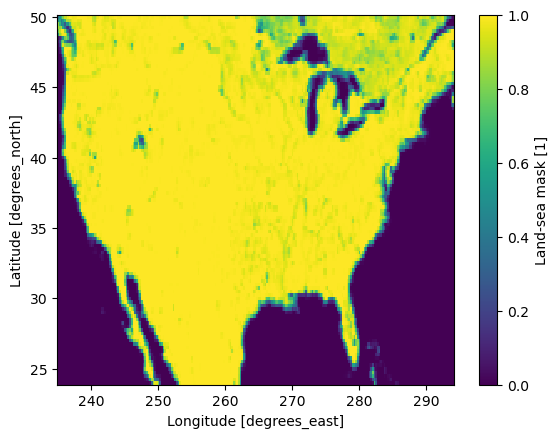

In [8]:

#dsm['lsmask']=xr.where(dsm['lsmask']>0,1,np.nan)
dsm['lsmask'].plot()


In [9]:
datadir='/Projects/era5/Dailies/monolevel/'
files=[f'{datadir}/air.2m.{iyear}.nc' for iyear in range(1981,2010+1)]



In [28]:
def preprocess(ds):
    return ds.sel(lon=slice(min_lon,max_lon),lat=slice(min_lat,max_lat)).drop_dims('nbnds')
ds=xr.open_mfdataset(files[10:12],combine='nested', preprocess=preprocess)


In [29]:
temp_var='air'
ds

<xarray.Dataset> Size: 73MB
Dimensions:  (lat: 105, lon: 237, time: 731)
Coordinates:
  * lat      (lat) float64 840B 50.0 49.75 49.5 49.25 ... 24.75 24.5 24.25 24.0
  * lon      (lon) float64 2kB 235.0 235.2 235.5 235.8 ... 293.5 293.8 294.0
  * time     (time) datetime64[ns] 6kB 1991-01-01 1991-01-02 ... 1992-12-31
Data variables:
    air      (time, lat, lon) float32 73MB dask.array<chunksize=(1, 105, 237), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.6
    title:                     daily mean ERA5 Reanalysis
    comments:                  Obtained at NCAR and converted to PSD NetCDF f...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data can be used at PSD. Do not redistri...
    creator_name:              NOAA/ESRL PSD
    ...                        ...
    grid_specification:        0.25 degree x 0.25 degree from 90N to 90S and ...
    original_source:           ECMWF: https://cds.climate.copernicus.eu, Cope...
    source:                    NCAR, Boulder CO
    creation_date:             2020-02-15T00:25:30Z
    history:                   created 2020/02 by DRM (chunked, deflated non-...
    dataset_title:             ERA5 Reanalyses at PSL

In [30]:
temp_data=ds['air']
ds['air']=ds['air'].where(dsm['lsmask']>0)
ds[temp_var]=ds[temp_var] * 9/5 - 459.67

In [31]:
temp_var='air'
start_month=8;end_month=7
ilon=253.25
ilat=45
year=1991

In [18]:
from scipy.signal import find_peaks, argrelextrema

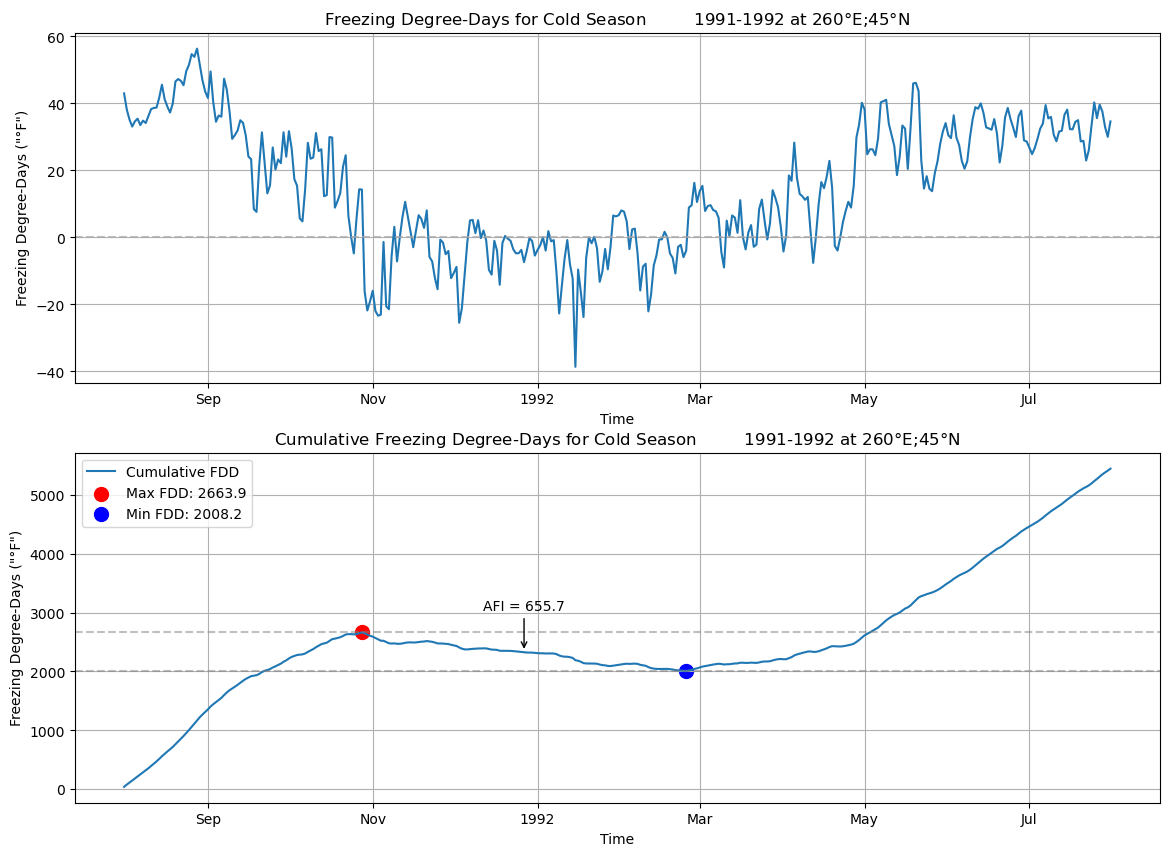

In [87]:
ilon=260
ilat=45

plot_cumulative_fdd(ds, ilon,ilat,temp_var=temp_var)


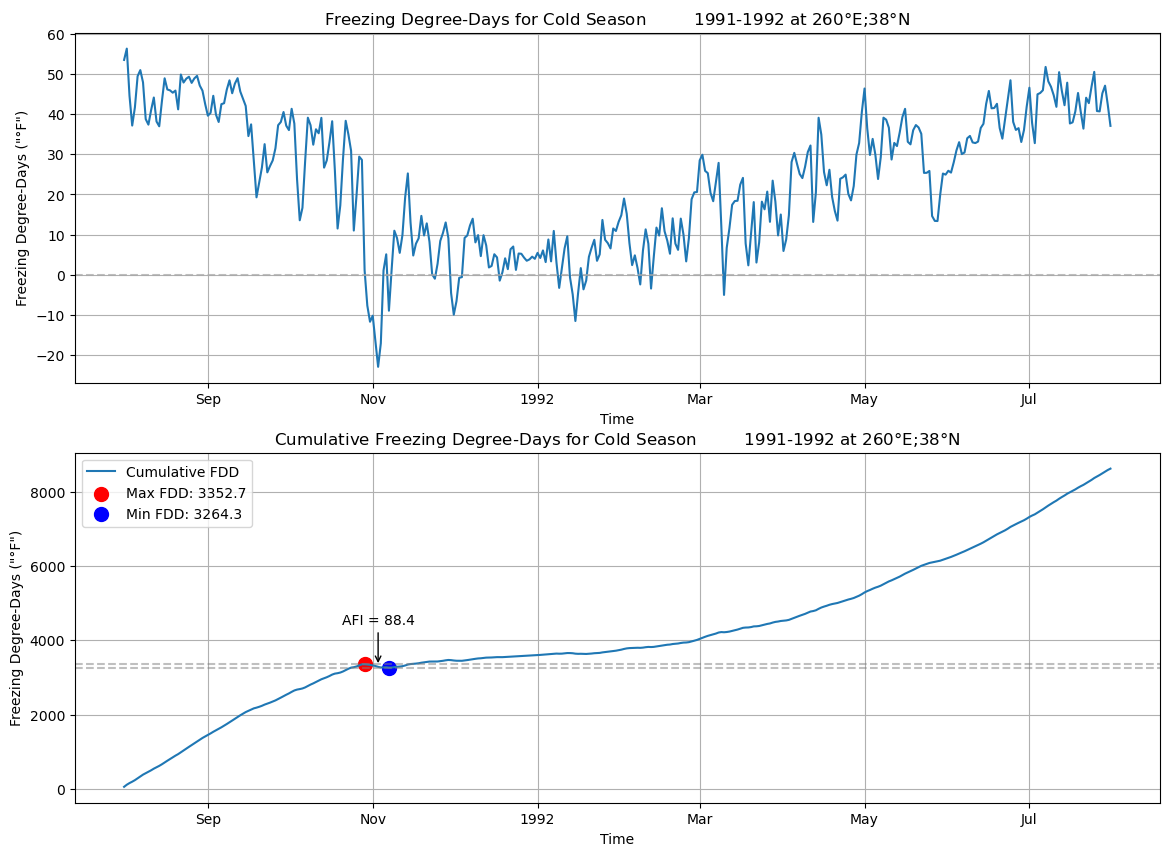

In [88]:
ilon=260
ilat=38

plot_cumulative_fdd(ds, ilon,ilat,temp_var=temp_var)

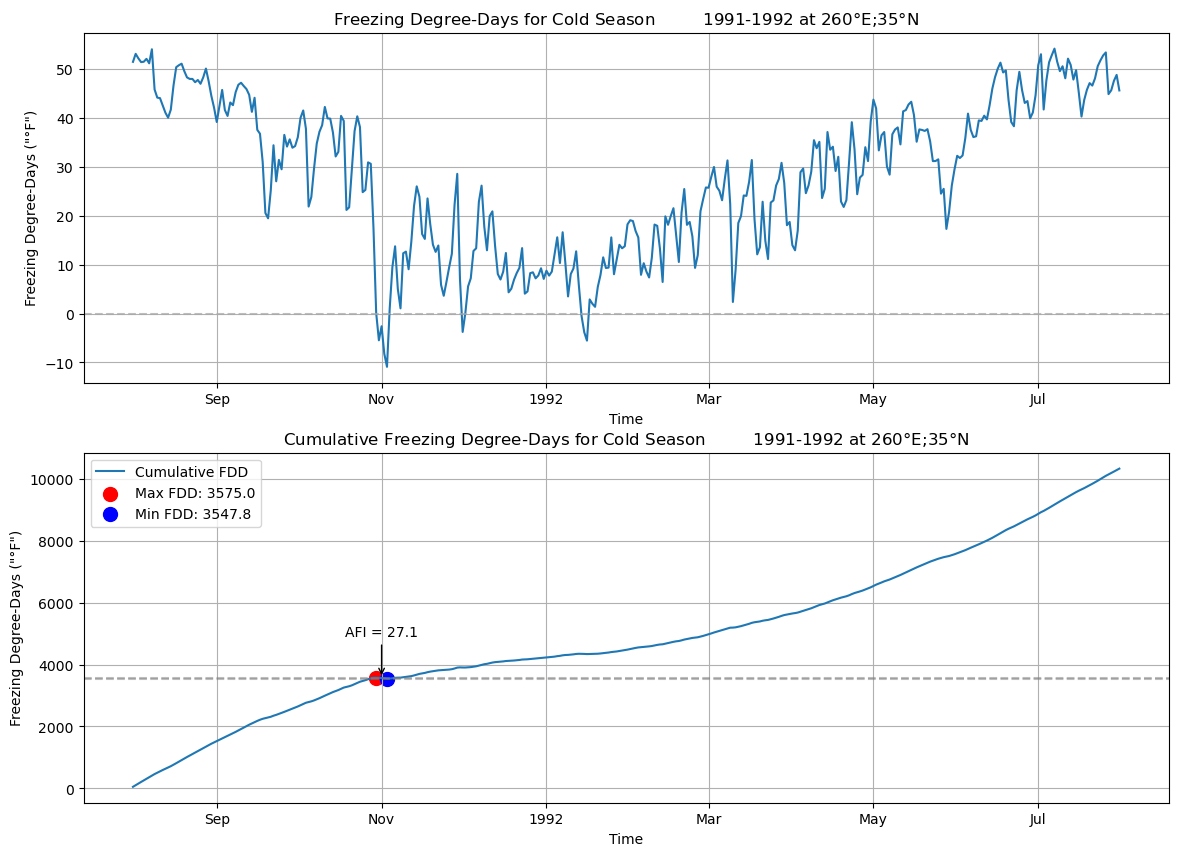

In [89]:
ilon=260
ilat=35

plot_cumulative_fdd(ds, ilon,ilat,temp_var=temp_var)

In [69]:
maxima

array([ 90, 121, 165])

In [70]:
minima

array([ 94, 122, 168])

In [76]:
maxima[np.where(maxima<=89)[0]]


array([], dtype=int64)